We would like you to analyze and present elaborated data from an agricultural application map.
The yield maps are georeferenced files created by agricoltural machinery (such as tractors, harvester, etc.) containing the actual result of harvesting products on the field. In this case, you have a harvesting in the Jolanda Di Savoia plains.

Below is a brief description of the attributes of the file:
•	Longitudin/Latitudine geo-references of the acquisitions, CSR is in EPSG:4326
•	RESAKG the amount of the product harvested acquired, in kg.
•	VELOCITA, the speed of the harvester, in km/h.
•	AREA, the area harvested since the last acquisition, in mq.
•	UMIDITA, the average relative humidity of the product.

You will have to process the following: 
1. The data shall be treated to cleanse them for further processing (explain the steps taken). 
2. Spatially interpolate the resulted data (explain the algorithm/s used, input data format, output data format).  
3. Correlate the results with an average vegetational vigor index of your choice calculated over the last year for that field.


Guidelines 
• The result code should be implemented in Python.
• You can use any framework you desire, and any tool you wish. 
• You should enclose the code in a Jupiter notebook, with both code, images and explaining text. 
• Any other extra feature/idea can be included; it will be considered as a bonus. 
  
What we expect from you
• Upload project files (source code and any other files) to an online git repository of your choice (in case a private repository, send us invitation). 
• the notebook should contain: 
o Design decisions as well data base selection and data modeling decisions. 
o Instructions on how to test/build/deploy the application. 
• Clean and readable source code. 
• In case of an unfinished functionality please explain what went wrong:
o In case of an unfinished implementation due to time management issues please indicate the steps that you would follow, to finish it and a rough estimation. 
o In case of a bug please include details on how to reproduce it and your ideas or 
suggestions on how to solve it. 
  
Good luck! 



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

%matplotlib inline


In [4]:
input_file = "resa_girasole_2022.gpkg"
girasoli = gpd.read_file(input_file)

girasoli.head()

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,NaN,POINT (1333142.685 5597543.903)
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,NaN,POINT (1333141.706 5597572.841)
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,NaN,POINT (1333141.672 5597604.934)
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.1,POINT (1333142.284 5597633.165)
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.1,POINT (1333142.195 5597662.213)


<b> Parte 1. </b>
Inizio esplorando un po' i dati per vedere cosa c'è dentro in termini di tipologia di dati, trend, valori, dati mancanti

In [7]:
girasoli.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1962 entries, 0 to 1961
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Data/Ora    1962 non-null   object  
 1   Longitudin  1962 non-null   object  
 2   Latitudine  1962 non-null   object  
 3   RESAKG      1962 non-null   float64 
 4   VELOCITA    1962 non-null   float64 
 5   AREA        1962 non-null   float64 
 6   UMIDITA     1925 non-null   float64 
 7   geometry    1962 non-null   geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 122.8+ KB


In [9]:
girasoli.describe()
#qui vedo anche che umidità ha diversi NaN (il conteggio è più basso)

,RESAKG,VELOCITA,AREA,UMIDITA
count,1962.000000,1962.000000,1962.000000,1925.000000
mean,2255.285423,4.903976,143.032629,27.022805
std,699.827651,0.614924,17.935293,6.154021
min,50.000000,0.780000,22.750000,18.600000
25%,1792.500000,4.570000,133.292000,22.200000
50%,2300.000000,4.900000,142.917000,25.800000
75%,2730.000000,5.180000,151.083000,30.200000
max,4880.000000,10.910000,318.208000,50.100000


In [11]:
import locale
import matplotlib.dates as mdates

#locale.setlocale(locale.LC_TIME, 'italian')  # Windows
locale.setlocale(locale.LC_TIME, 'it_IT.UTF-8')

girasoli['data_ora'] = pd.to_datetime(girasoli['Data/Ora'], format='%d %b %Y, %H:%M:%S', dayfirst=True)
girasoli['day'] = girasoli['data_ora'].dt.date
girasoli.groupby('day').size()

day
2022-08-31     190
2022-09-03    1455
2022-09-05     317
dtype: int64

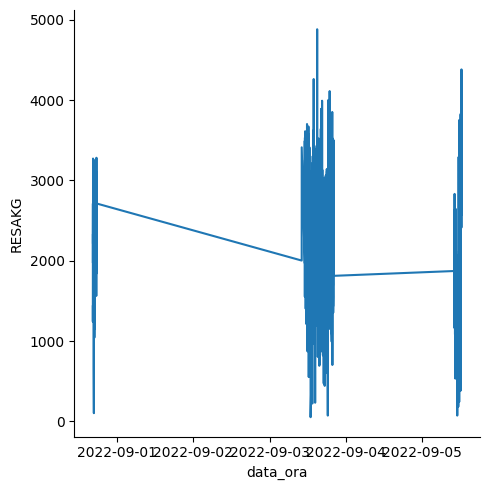

In [13]:
trend_p = sns.relplot(
    data=girasoli, kind="line",
    x="data_ora", y="RESAKG"
)
plt.show(trend_p)

In [100]:
girasoli.groupby('geometry').size().sort_values(ascending=False)
#Vedendo che per ogni punto c'è una sola osservazione risolvo il potenziale "problema" dato dal fatto che si tratta di dati temporali
#per cui ignorerò questo fatto e li tratterò solo come dati spaziali (come previsto)

geometry
POINT (1331945.511 5597529.364)    1
POINT (1332440.537 5597888.284)    1
POINT (1332481.859 5597905.792)    1
POINT (1332470.36 5597902.133)     1
POINT (1332450.634 5597913.329)    1
                                  ..
POINT (1332803.74 5597795.99)      1
POINT (1332782.199 5597800.261)    1
POINT (1332793.532 5597794.121)    1
POINT (1332753.067 5597799.067)    1
POINT (1333911.758 5597544.83)     1
Length: 1962, dtype: int64

Ora vorrei plottare i dati geometrici e vedere i valori delle varie colonne nello spazio

Dall'head vedevo che i punti geometria hanno coordinate diverse dalla combinazione della latitudine e longitudine, strano

In [15]:
from shapely import wkt
from shapely.geometry import Point
import geopandas
import geodatasets
from geodatasets import get_path

C:\Users\AntoninoBrillante\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


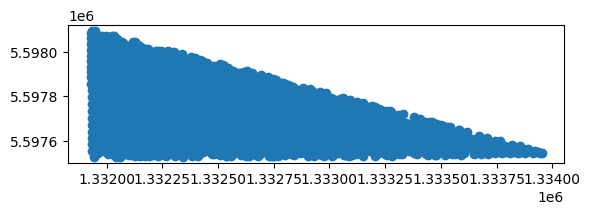

In [17]:
p = girasoli.plot()
plt.show(p)

Ho trovato online su ISTAT i file shp per comune, su cui costruire le mappe. 
Il mio obiettivo di questa fase era contestualizzare i punti rispetto all'area geografica. In realtà qui ho solo plottato i punti su mappe semplici con i confini amministrativi, che a posteriori non è stato troppo utile se non a farmi uniformare i dati e creare una nuova colonna geometria

In [21]:
comuni = gpd.read_file("Limiti01012024_g/Com01012024_g/Com01012024_g_WGS84.shp")
province = gpd.read_file("Limiti01012024_g/ProvCM01012024_g/ProvCM01012024_g_WGS84.shp")


In [22]:
comuni.head(2)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Leng,Shape_Area,geometry
0,1,1,1,0,201,1001,001001,Agliè,0,0,16075.204018,1.328507e+07,"POLYGON ((404703.561 5026682.656, 405359.557 5..."
1,1,1,1,0,201,1002,001002,Airasca,0,0,16695.878036,1.578186e+07,"POLYGON ((380700.909 4977305.52, 381122.28 497..."


In [25]:
province.head(2)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Leng,Shape_Area,geometry
0,1,1,1,201,201,-,Torino,Torino,TO,Città metropolitana,539673.515132,6.828372e+09,"POLYGON ((411015.294 5049971.205, 411266.165 5..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,Provincia,417425.499113,2.082173e+09,"POLYGON ((438328.706 5087208.167, 439028.998 5..."


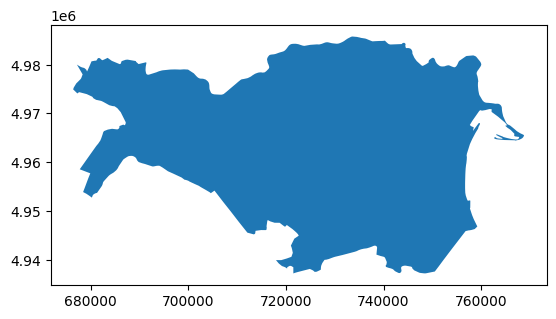

In [27]:
ferrara = province[province['DEN_PROV'] == 'Ferrara']

p_ferrara = ferrara.plot()
plt.show(p_ferrara)

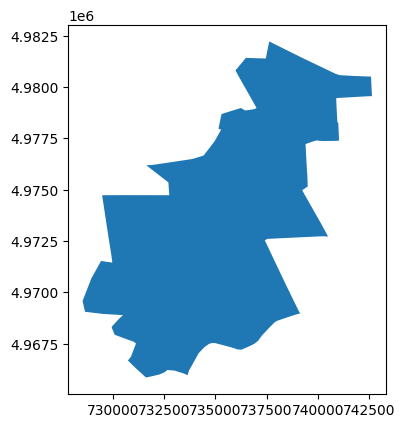

In [29]:
jolanda = comuni[comuni['COMUNE'] == 'Jolanda di Savoia']

p_jolanda = jolanda.plot()
plt.show(p_jolanda)

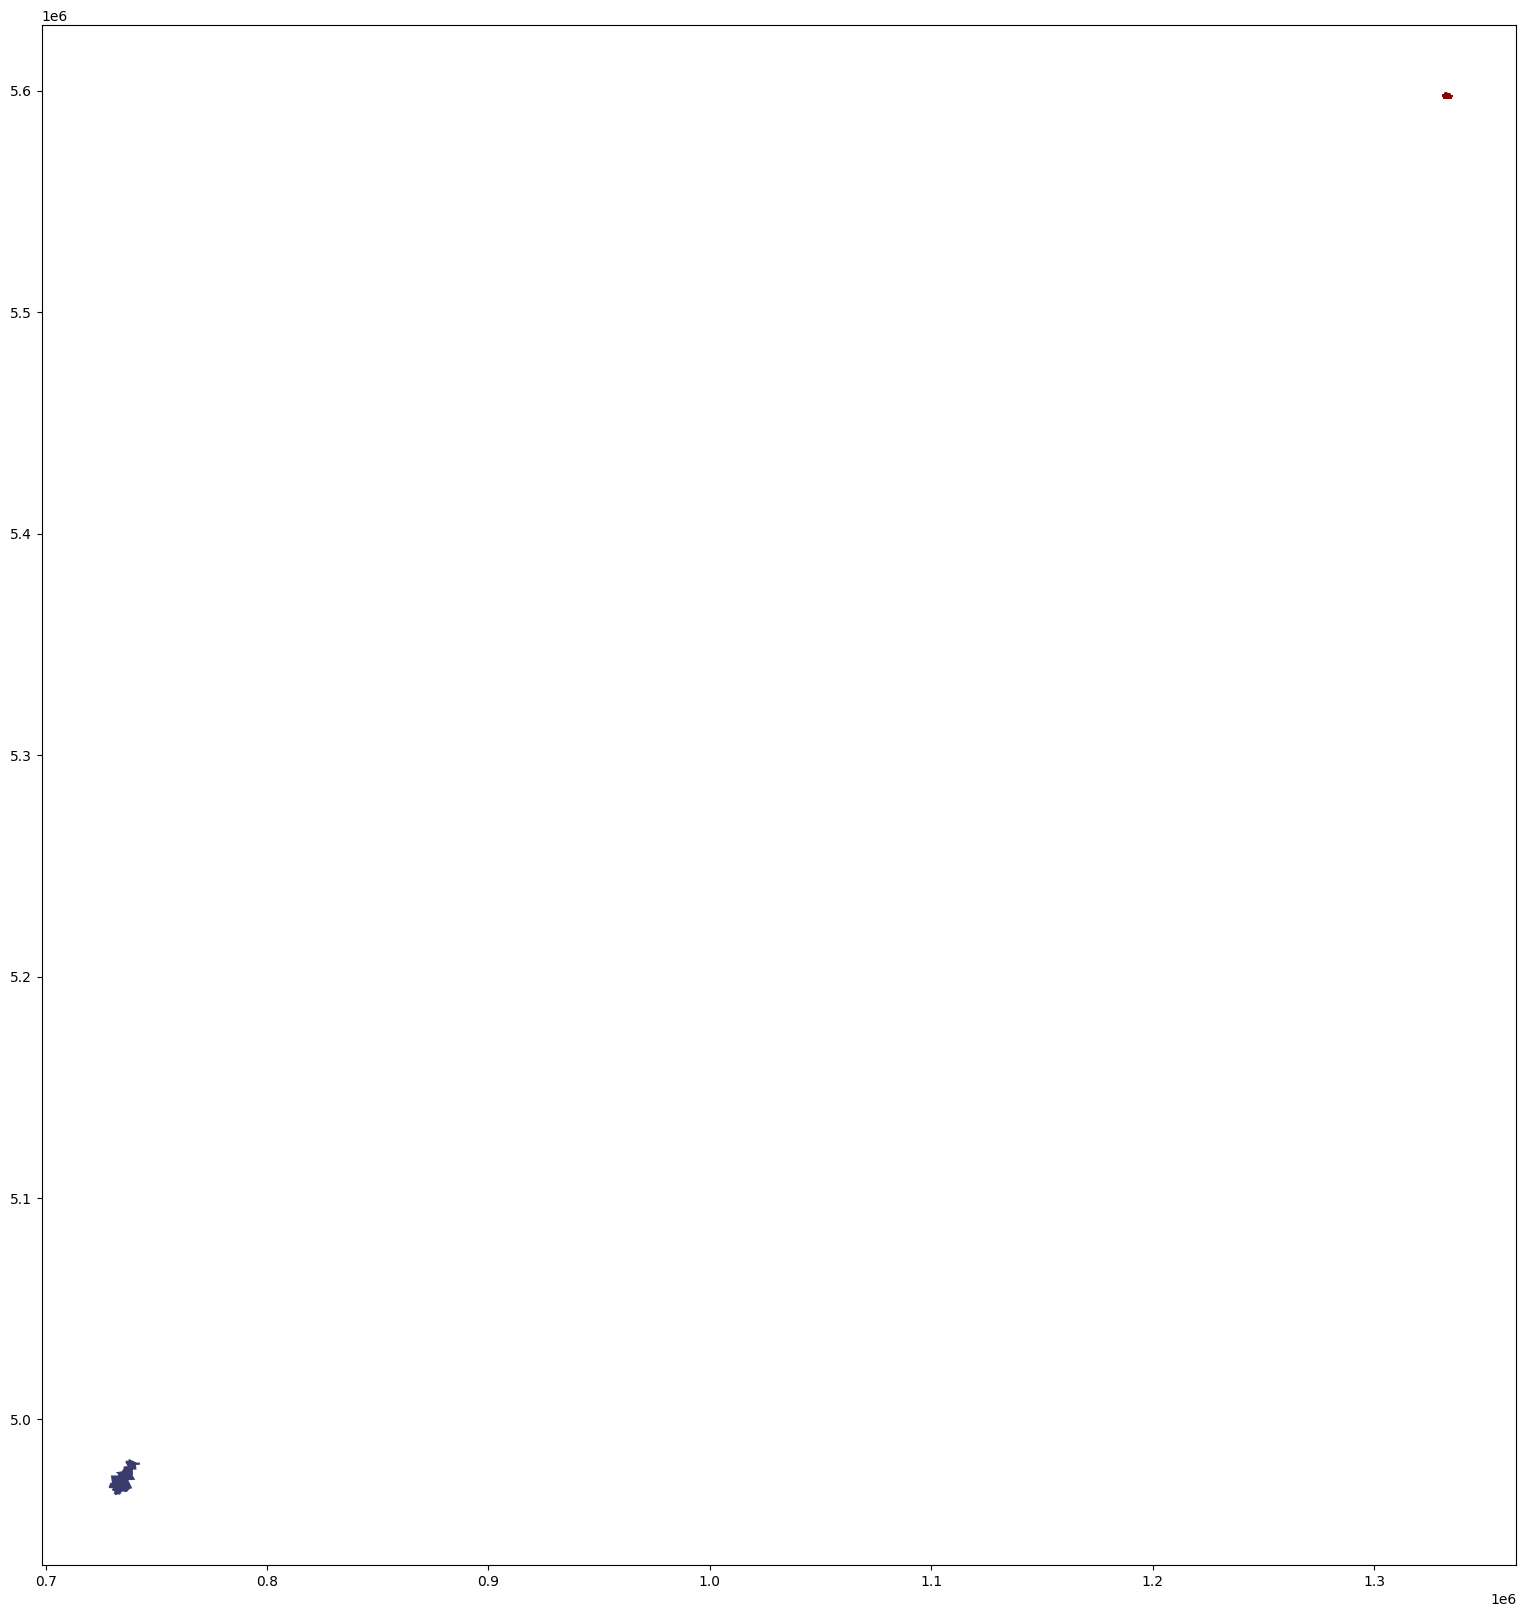

In [31]:
fig, ax = plt.subplots(1, figsize=(30,20))
base_j = jolanda.plot(ax=ax, color='#3B3C6E')

j_completo = girasoli.plot(ax=base_j, color='darkred', marker="*", markersize=10);
plt.show(j_completo)

Non capisco perche siano cosi lontani, suppongo che ci possa essere qualche differenza in termini di tipologia di coordinate e quindi provo a standardizzare la mappa scaricata in modo da avere latitudine e longitudine, allo stesso modo del mio nuovo dataset che mi creo qua sotto

In [33]:
girasoli['long'] = girasoli['Longitudin'].str.replace(',', '.').astype(float)
girasoli['lat'] = girasoli['Latitudine'].str.replace(',', '.').astype(float)

girasoli['coordinates'] = girasoli[['long','lat']].values.tolist()
girasoli['coordinates'] = girasoli['coordinates'].apply(Point)

girasoli_new = girasoli.drop(['Longitudin','Latitudine'], axis=1)
# Convert the count df to geodf
girasoli_new = geopandas.GeoDataFrame(girasoli_new, geometry='coordinates')
girasoli_new = girasoli_new.drop(['geometry'], axis=1)

girasoli_new.head()



,Data/Ora,RESAKG,VELOCITA,AREA,UMIDITA,data_ora,day,long,lat,coordinates
0,"5 set 2022, 10:08:09",1870.0,4.80,140.000,NaN,2022-09-05 10:08:09,2022-09-05,11.975824,44.847491,POINT (11.97582 44.84749)
1,"5 set 2022, 10:08:24",1270.0,4.83,140.875,NaN,2022-09-05 10:08:24,2022-09-05,11.975816,44.847675,POINT (11.97582 44.84768)
2,"5 set 2022, 10:08:40",1420.0,4.78,139.417,NaN,2022-09-05 10:08:40,2022-09-05,11.975815,44.847879,POINT (11.97582 44.84788)
3,"5 set 2022, 10:08:55",2010.0,4.85,141.458,33.1,2022-09-05 10:08:55,2022-09-05,11.975821,44.848059,POINT (11.97582 44.84806)
4,"5 set 2022, 10:09:10",1320.0,4.80,140.000,33.1,2022-09-05 10:09:10,2022-09-05,11.975820,44.848244,POINT (11.97582 44.84824)


In [35]:
jolanda_stand = jolanda.to_crs(epsg=4326)
jolanda_stand.head()

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Leng,Shape_Area,geometry
4035,2,8,38,0,38,38010,038010,Jolanda di Savoia,0,0,62774.264569,1.086059e+08,"POLYGON ((12.03249 44.94597, 12.05272 44.93842..."


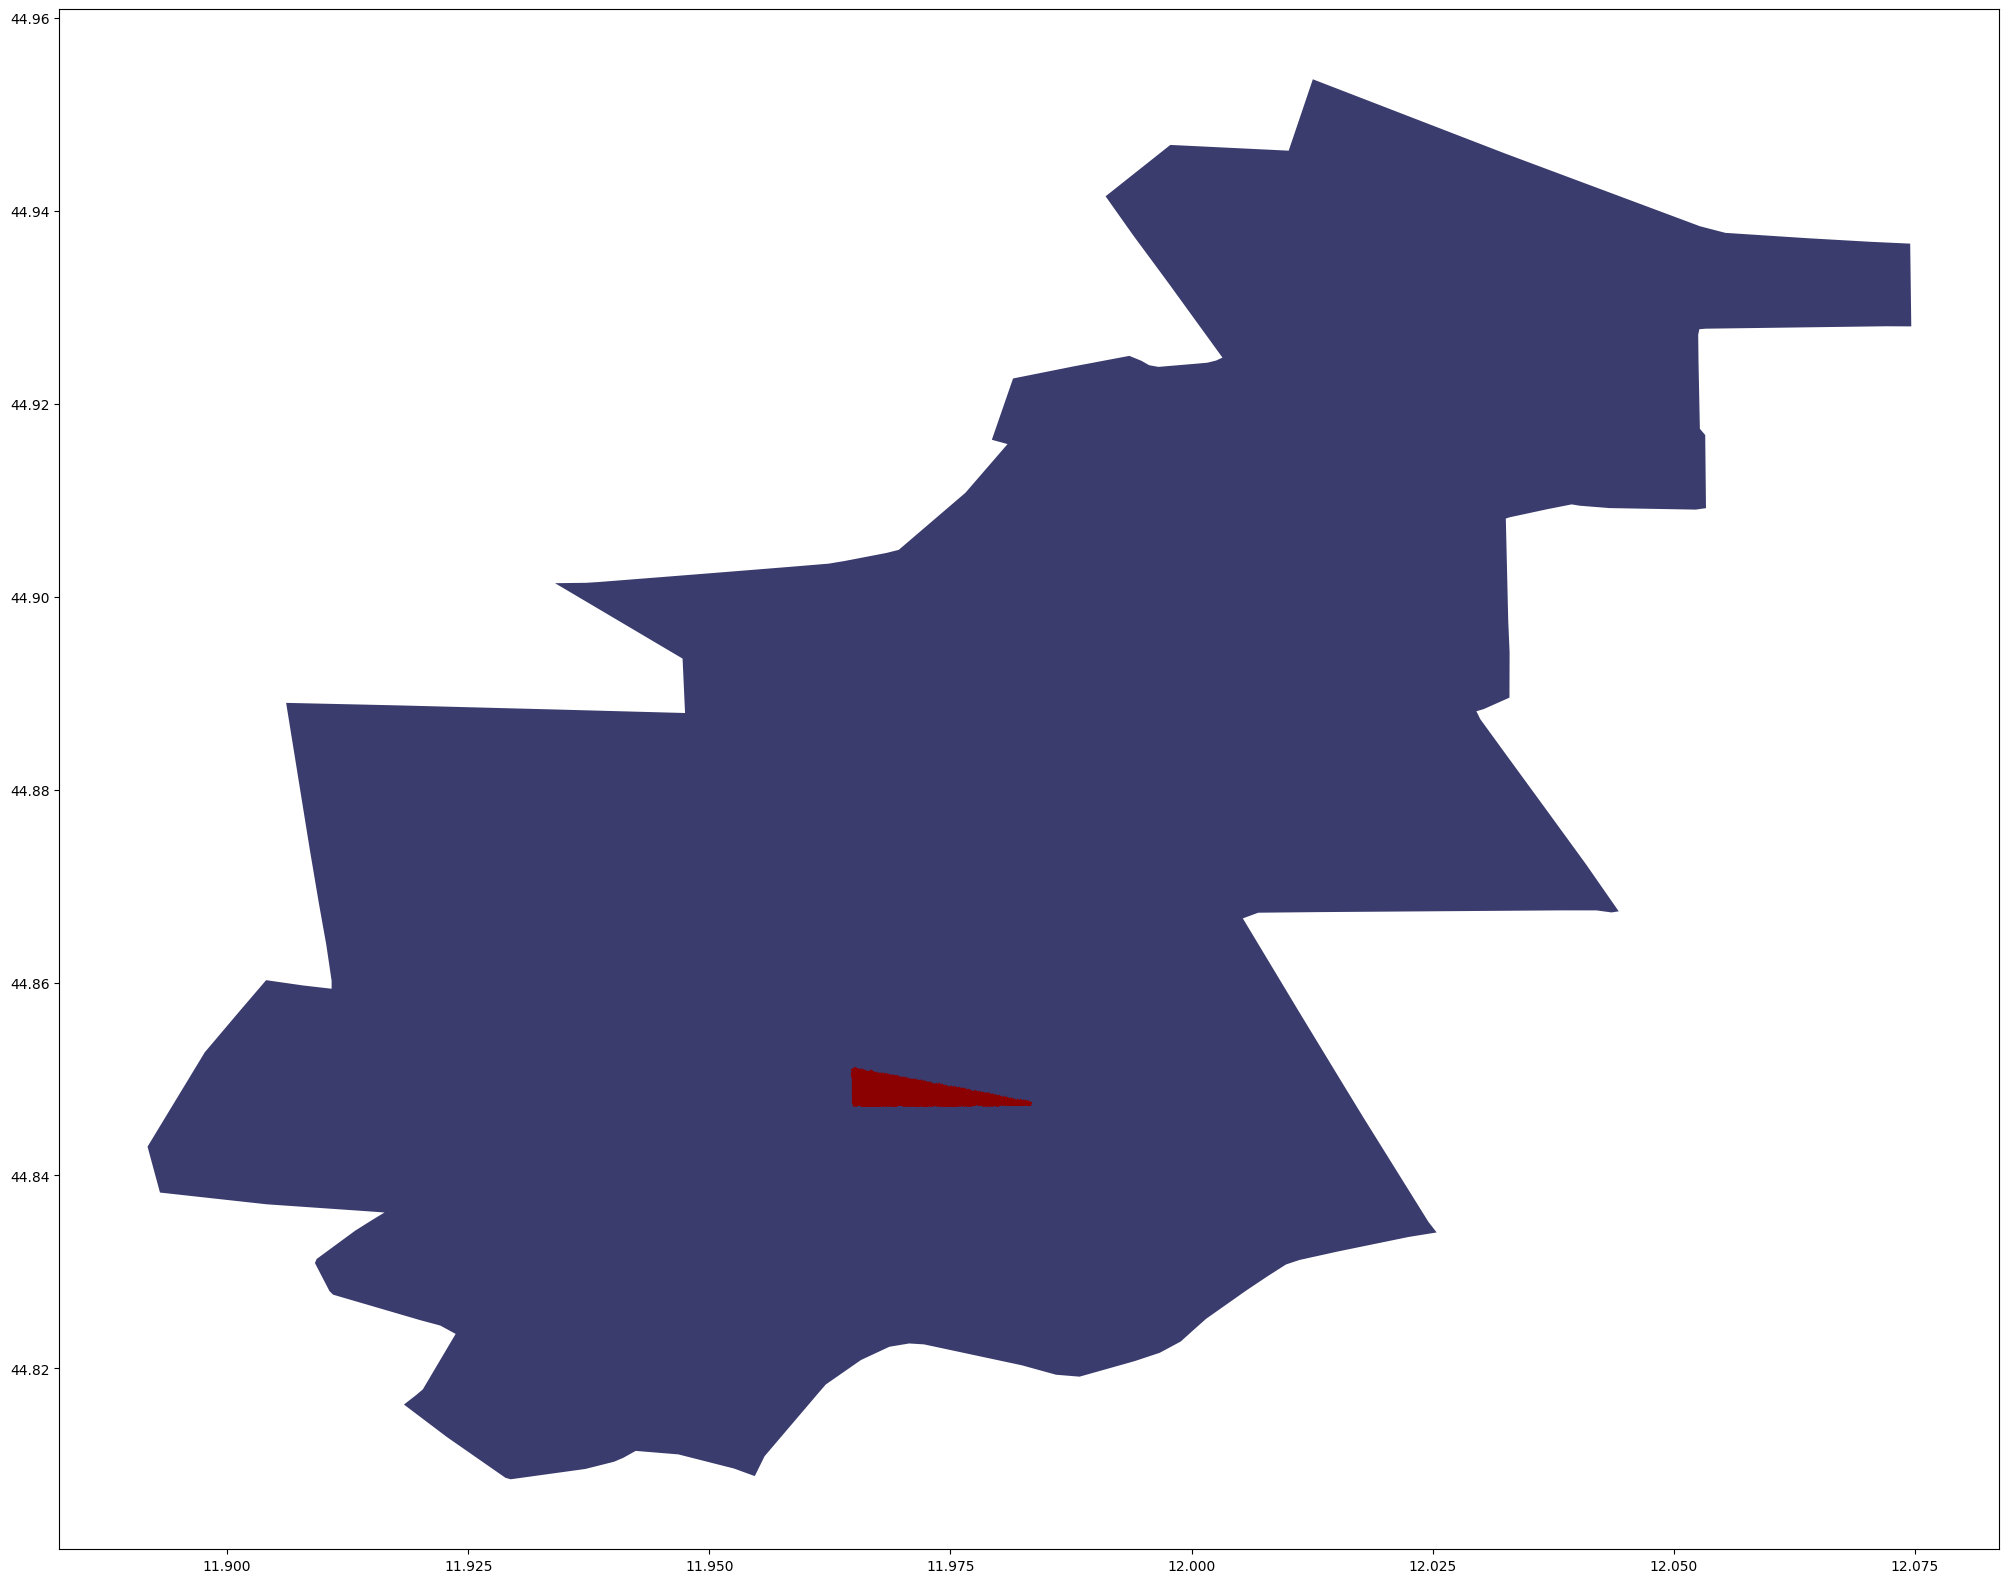

In [37]:
fig, ax = plt.subplots(1, figsize=(30,20))
base_j = jolanda_stand.plot(ax=ax, color='#3B3C6E')

j_completo = girasoli_new.plot(ax=base_j, color='darkred', marker="*", markersize=10);
plt.show(j_completo)

Credo proprio che sia stato abbastanza inutile plottare con la mappa, ma ormai è fatto e lo lascio

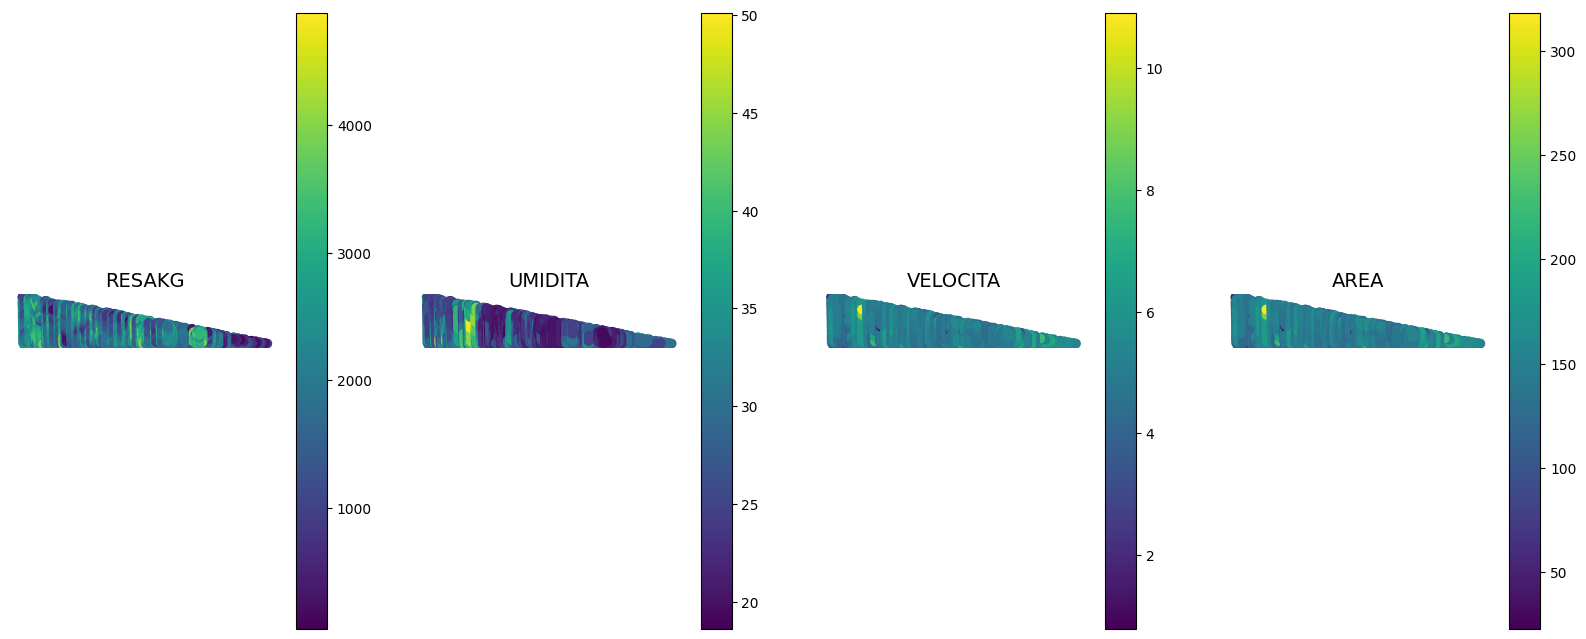

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(5 * 4, 8))

for ax, column in zip(axes, ['RESAKG','UMIDITA','VELOCITA','AREA']):
    girasoli_new.plot(column=column, cmap="viridis", legend=True, ax=ax)
    ax.set_title(column, fontsize=14)
    ax.axis("off")  

plt.show()

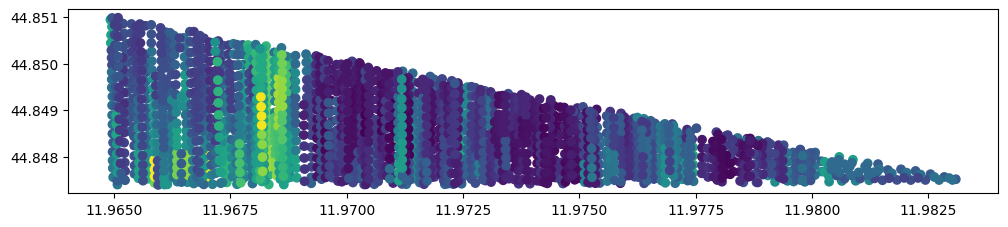

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
umid = girasoli_new.plot(column="UMIDITA",ax=ax)
plt.show(umid)
#Voglio vedere il dettaglio di umidità, colonna con i missing

2. Ora procedo a imputare i dati mancanti per umidità. Cercando tra i vari metodi di imputazione per dati di questo tipo, ho trovato che la regressione KNN è un metodo comunemente usato e quindi scelgo di usarlo, non avendo esperienza con gli altri modelli

In [44]:
girasoli_imputed = girasoli_new.copy() #assegno a un altro df in modo da tenermi il confronto tra i vecchi e nuovi dati

In [46]:
from sklearn.neighbors import KNeighborsRegressor

known_points = girasoli_imputed.dropna(subset=['UMIDITA'])
X_known = np.array(list(zip(known_points.geometry.x, known_points.geometry.y)))
y_known = known_points['UMIDITA']

unknown_points = girasoli_imputed[girasoli_imputed['UMIDITA'].isna()]
X_unknown = np.array(list(zip(unknown_points.geometry.x, unknown_points.geometry.y)))

knn_uniform = KNeighborsRegressor(n_neighbors=10, weights="uniform")
knn_uniform.fit(X_known, y_known)
predicted_values = knn_uniform.predict(X_unknown)

girasoli_imputed.loc[girasoli_imputed['UMIDITA'].isna(), 'UMIDITA'] = predicted_values

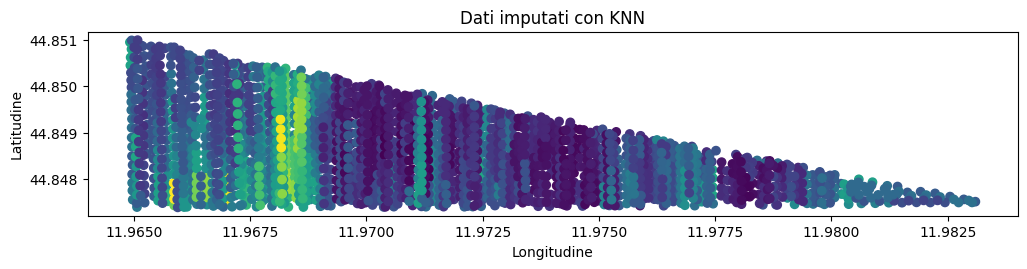

In [50]:
# Visualizzazione del risultato su una mappa
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
imputed = girasoli_imputed.plot(column='UMIDITA', ax=ax, cmap='viridis')
plt.title('Dati imputati con KNN')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.show(imputed)

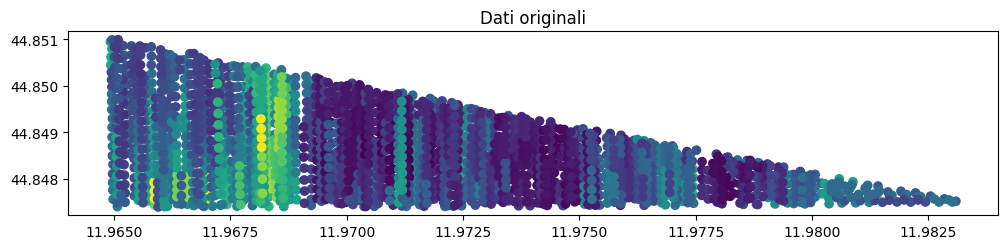

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
umid = girasoli_new.plot(column="UMIDITA",ax=ax)
plt.title('Dati originali')
plt.show(umid)

PARTE 3. Ho scaricato una mappa con NDVI (che ho trovato essere un indicatore vegetativo molto comune) da Sentinel data, importo e plotto i nostri dati. Ho scaricato il formato TIFF, in modo da avere oltre all'immagine anche i dati numerici.

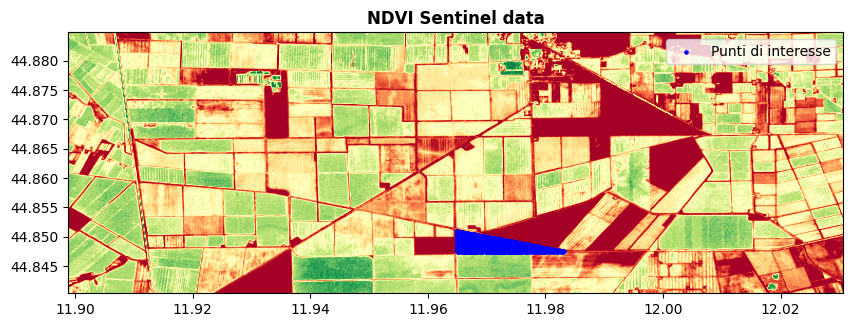

In [65]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Carica il file GeoTIFF
file_path = '2024-11-03-00_00_2024-11-03-23_59_Sentinel-2_L2A_NDVI.tiff'

with rasterio.open(file_path) as src:
    ndvi_data = src.read(1)
    transform = src.transform  
    crs = src.crs  

fig, ax = plt.subplots(figsize=(10, 10))
show(ndvi_data, transform=transform, cmap='RdYlGn',ax=ax, title='NDVI Sentinel data')
girasoli_imputed.plot(ax=ax, color='blue', markersize=5, label='Punti di interesse')
plt.legend()
plt.show()

In [73]:
#Qui metto insieme i dati di NDVI con i miei dati
values = []
for point in girasoli_imputed.geometry:
    row, col = src.index(point.x, point.y)
    value = ndvi_data[row, col]
    values.append(value)

girasoli_imputed['NDVI'] = values

girasoli_imputed.head()

,Data/Ora,RESAKG,VELOCITA,AREA,UMIDITA,data_ora,day,long,lat,coordinates,NDVI
0,"5 set 2022, 10:08:09",1870.0,4.80,140.000,27.12,2022-09-05 10:08:09,2022-09-05,11.975824,44.847491,POINT (11.97582 44.84749),0.38
1,"5 set 2022, 10:08:24",1270.0,4.83,140.875,27.73,2022-09-05 10:08:24,2022-09-05,11.975816,44.847675,POINT (11.97582 44.84768),0.38
2,"5 set 2022, 10:08:40",1420.0,4.78,139.417,28.19,2022-09-05 10:08:40,2022-09-05,11.975815,44.847879,POINT (11.97582 44.84788),0.31
3,"5 set 2022, 10:08:55",2010.0,4.85,141.458,33.10,2022-09-05 10:08:55,2022-09-05,11.975821,44.848059,POINT (11.97582 44.84806),0.31
4,"5 set 2022, 10:09:10",1320.0,4.80,140.000,33.10,2022-09-05 10:09:10,2022-09-05,11.975820,44.848244,POINT (11.97582 44.84824),0.31


In [75]:
correlation_matrix = girasoli_imputed.corr(numeric_only=True)

# Calcolo la correlazione di tutte le variabili quantitative con NDVI
correlation_matrix['NDVI']

RESAKG      0.234722
VELOCITA    0.069120
AREA        0.069120
UMIDITA    -0.110603
long       -0.211305
lat        -0.078242
NDVI        1.000000
Name: NDVI, dtype: float64